# Yoga Pose Detection - Local Version

**Setup Instructions:**
1. Install dependencies: `pip install mediapipe opencv-python pandas numpy scikit-learn matplotlib seaborn joblib`
2. Download the Activities folder to: `/Users/azimusmanov/Documents/CS_396/final_proj/Activities`
3. Organize videos like: `Activities/Lunge/*.mp4`, `Activities/Tree/*.MOV`, etc.
4. Run cells sequentially to generate `yoga_pose_model.pkl`
5. Use the model with `realtime_yoga_pose.py` for webcam feedback!


Processing Videos Using MediaPipe


In [1]:
#relevant imports
import mediapipe as mp
import cv2
import pandas as pd
import os
import numpy as np


In [2]:
#loading all the files
base_dir = '/Users/azimusmanov/Documents/CS_396/final_proj/Activities'
video_files = []
for base, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith('.mp4') or file.endswith('.MOV'):
            full_path = os.path.join(base, file)
            video_files.append(full_path)

print(f'Found {len(video_files)} videos')


Found 40 videos


In [3]:
mp_pose = mp.solutions.pose
#can play around with the hyperparameters below
pose = mp_pose.Pose(static_image_mode=False, model_complexity=2, enable_segmentation=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)


complete_pose_data = []

videos_processed = 0

for video_file in video_files:
  videos_processed += 1
  print(f'processing video {videos_processed}/{len(video_files)}: {video_file}')

  activity = os.path.basename(os.path.dirname(video_file))
  vid = cv2.VideoCapture(video_file)

  per_video_frame_data = []
  frame_num = 0

  while vid.isOpened():
    sucsess, frame = vid.read()
    if not sucsess: #migh be unabel to read the video
      break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) #had to change this since cv2 reads it in BGR order
    #https://www.geeksforgeeks.org/python/python-opencv-cv2-cvtcolor-method/

    results = pose.process(rgb)

    if results.pose_landmarks:
      for i, kp in enumerate(results.pose_landmarks.landmark):
        per_video_frame_data.append({
            'activity': activity,
            'video_file': video_file,
            'frame': frame_num,
            'kp_idx': i,
            'x': kp.x,
            'y': kp.y,
            'z': kp.z,
            'visibility': kp.visibility
        })

    frame_num += 1
  vid.release()
  complete_pose_data.extend(per_video_frame_data)

pose.close()
raw_pose_data_df = pd.DataFrame(complete_pose_data)
print(raw_pose_data_df.head())
print(raw_pose_data_df.info())





processing video 1/40: /Users/azimusmanov/Documents/CS_396/final_proj/Activities/Tree/tree_9.mp4
processing video 1/40: /Users/azimusmanov/Documents/CS_396/final_proj/Activities/Tree/tree_9.mp4


I0000 00:00:1764098295.599357 30238708 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1764098295.677025 30239671 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764098295.713080 30239671 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/azimusmanov/Documents/CS_396/final_proj/venv312/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/azimusmanov/Documents/CS_396/final_proj/venv312/lib/python3.12/site-packages/google/protobuf/symbol_

processing video 2/40: /Users/azimusmanov/Documents/CS_396/final_proj/Activities/Tree/tree_8.mp4
processing video 3/40: /Users/azimusmanov/Documents/CS_396/final_proj/Activities/Tree/tree_3.mp4
processing video 3/40: /Users/azimusmanov/Documents/CS_396/final_proj/Activities/Tree/tree_3.mp4
processing video 4/40: /Users/azimusmanov/Documents/CS_396/final_proj/Activities/Tree/tree_6.mp4
processing video 4/40: /Users/azimusmanov/Documents/CS_396/final_proj/Activities/Tree/tree_6.mp4
processing video 5/40: /Users/azimusmanov/Documents/CS_396/final_proj/Activities/Tree/tree_7.mp4
processing video 5/40: /Users/azimusmanov/Documents/CS_396/final_proj/Activities/Tree/tree_7.mp4
processing video 6/40: /Users/azimusmanov/Documents/CS_396/final_proj/Activities/Tree/tree_5.mp4
processing video 6/40: /Users/azimusmanov/Documents/CS_396/final_proj/Activities/Tree/tree_5.mp4
processing video 7/40: /Users/azimusmanov/Documents/CS_396/final_proj/Activities/Tree/tree_4.mp4
processing video 7/40: /Users/

Calculate Joint Angles


In [4]:
def calculate_angles_from_kp(kp1, kp2, kp3):
  kp1 = np.array(kp1)
  kp2 = np.array(kp2)
  kp3 = np.array(kp3)

  vec1 = kp2 - kp1
  vec2 = kp3 - kp2

  dot = np.dot(vec1, vec2)
  norm1 = np.linalg.norm(vec1)
  norm2 = np.linalg.norm(vec2)

  if norm1 == 0 or norm2 == 0:
    return 0.0

  cosine_ang = dot / (norm1 * norm2)
  cosine_ang = np.clip(cosine_ang, -1.0, 1.0)
  angle = np.arccos(cosine_ang)
  return np.degrees(angle)


Get the joints/kps of interest

In [5]:
def get_coordinates(landmarks, kp_idx):
  coords = landmarks[landmarks['kp_idx'] == kp_idx]
  if not coords.empty:
    return [coords['x'].iloc[0], coords['y'].iloc[0], coords['z'].iloc[0]]

Create Dataframe of Joint Angles

In [6]:
import numpy as np

In [7]:
#calculated using info from complete pose data organized
pose_organized = raw_pose_data_df.groupby(['activity', 'video_file', 'frame'])
complete_angle_data = []

for (activity, video_file, frame), group in pose_organized:
  row = {
      'activity': activity,
      'video_file': video_file,
      'frame': frame
  }

  #Left Arm
  l_shoulder = get_coordinates(group, mp_pose.PoseLandmark.LEFT_SHOULDER.value)
  l_elbow = get_coordinates(group, mp_pose.PoseLandmark.LEFT_ELBOW.value)
  l_wrist = get_coordinates(group, mp_pose.PoseLandmark.LEFT_WRIST.value)

  if l_shoulder and l_elbow and l_wrist:
    row['left_elbow_angle'] = calculate_angles_from_kp(l_shoulder, l_elbow, l_wrist)
  else:
    row['left_elbow_angle'] = np.nan

  # Right Arm
  r_shoulder = get_coordinates(group, mp_pose.PoseLandmark.RIGHT_SHOULDER.value)
  r_elbow = get_coordinates(group, mp_pose.PoseLandmark.RIGHT_ELBOW.value)
  r_wrist = get_coordinates(group, mp_pose.PoseLandmark.RIGHT_WRIST.value)

  if r_shoulder and r_elbow and r_wrist:
    row['right_elbow_angle'] = calculate_angles_from_kp(r_shoulder, r_elbow, r_wrist)
  else:
    row['right_elbow_angle'] = np.nan

  # Left Leg
  l_hip = get_coordinates(group, mp_pose.PoseLandmark.LEFT_HIP.value)
  l_knee = get_coordinates(group, mp_pose.PoseLandmark.LEFT_KNEE.value)
  l_ankle = get_coordinates(group, mp_pose.PoseLandmark.LEFT_ANKLE.value)

  if l_hip and l_knee and l_ankle:
    row['left_knee_angle'] = calculate_angles_from_kp(l_hip, l_knee, l_ankle)
  else:
    row['left_knee_angle'] = np.nan

  if l_shoulder and l_hip and l_knee:
    row['left_hip_angle'] = calculate_angles_from_kp(l_shoulder, l_hip, l_knee)
  else:
    row['left_hip_angle'] = np.nan

  # Right Leg
  r_hip = get_coordinates(group, mp_pose.PoseLandmark.RIGHT_HIP.value)
  r_knee = get_coordinates(group, mp_pose.PoseLandmark.RIGHT_KNEE.value)
  r_ankle = get_coordinates(group, mp_pose.PoseLandmark.RIGHT_ANKLE.value)

  if r_hip and r_knee and r_ankle:
    row['right_knee_angle'] = calculate_angles_from_kp(r_hip, r_knee, r_ankle)
  else:
    row['right_knee_angle'] = np.nan

  if r_shoulder and r_hip and r_knee:
    row['right_hip_angle'] = calculate_angles_from_kp(r_shoulder, r_hip, r_knee)
  else:
    row['right_hip_angle'] = np.nan


  complete_angle_data.append(row)

complete_angle_data_df = pd.DataFrame(complete_angle_data)
print(complete_angle_data_df.head())
print(complete_angle_data_df.info())



  activity                                         video_file  frame  \
0    Cobra  /Users/azimusmanov/Documents/CS_396/final_proj...      0   
1    Cobra  /Users/azimusmanov/Documents/CS_396/final_proj...      1   
2    Cobra  /Users/azimusmanov/Documents/CS_396/final_proj...      2   
3    Cobra  /Users/azimusmanov/Documents/CS_396/final_proj...      3   
4    Cobra  /Users/azimusmanov/Documents/CS_396/final_proj...      4   

   left_elbow_angle  right_elbow_angle  left_knee_angle  left_hip_angle  \
0         57.028143          34.501678        69.723657       48.623939   
1         64.080692          33.133509       119.777129      111.964828   
2         77.772448          48.831158       148.225527      126.905865   
3         83.138063          51.409602       150.796166      134.703480   
4         70.101949          42.977235        51.714972      136.507389   

   right_knee_angle  right_hip_angle  
0        150.839976       106.527672  
1        140.339111        97.298192  

Combining the Per Frame Pose and Joint Angle Data

In [8]:
complete_pose_angle_df = pd.merge(raw_pose_data_df, complete_angle_data_df, on=['activity', 'video_file', 'frame'], how='left')
print(complete_pose_angle_df.head())
print(complete_pose_angle_df.info())


  activity                                         video_file  frame  kp_idx  \
0     Tree  /Users/azimusmanov/Documents/CS_396/final_proj...     65       0   
1     Tree  /Users/azimusmanov/Documents/CS_396/final_proj...     65       1   
2     Tree  /Users/azimusmanov/Documents/CS_396/final_proj...     65       2   
3     Tree  /Users/azimusmanov/Documents/CS_396/final_proj...     65       3   
4     Tree  /Users/azimusmanov/Documents/CS_396/final_proj...     65       4   

          x         y         z  visibility  left_elbow_angle  \
0  0.562590 -0.165796  0.039405    0.327095         56.745053   
1  0.563438 -0.188310  0.056961    0.152296         56.745053   
2  0.564496 -0.189616  0.056678    0.104594         56.745053   
3  0.565770 -0.189899  0.056814    0.156041         56.745053   
4  0.557043 -0.188525  0.032276    0.296945         56.745053   

   right_elbow_angle  left_knee_angle  left_hip_angle  right_knee_angle  \
0          34.569678        17.124166       26.324278

In [9]:
#saving the output
output_path = 'complete_pose_data_with_angles.csv'
complete_pose_angle_df.to_csv(output_path, index=False)
print(f'Saved to {output_path}')


Saved to complete_pose_data_with_angles.csv


Cleaning the Data (Keeping only the Frames where Motion is Minimal/Static Poses)


In [10]:
#reshaping the dataframe for eeasier indexing through per video

complete_pose_angle_df['kp_coord'] = 'kp_' + complete_pose_angle_df['kp_idx'].astype(str) + ' '

wide_df = complete_pose_angle_df.pivot_table(
    index=['activity', 'video_file', 'frame'],
    columns='kp_coord',
    values = ['x', 'y', 'z']
)

wide_df.columns = [f"{col[0]}_{col[1]}" for col in wide_df.columns]
wide_df = wide_df.reset_index()
print(wide_df.head())
print(wide_df.info())


  activity                                         video_file  frame  \
0    Cobra  /Users/azimusmanov/Documents/CS_396/final_proj...      0   
1    Cobra  /Users/azimusmanov/Documents/CS_396/final_proj...      1   
2    Cobra  /Users/azimusmanov/Documents/CS_396/final_proj...      2   
3    Cobra  /Users/azimusmanov/Documents/CS_396/final_proj...      3   
4    Cobra  /Users/azimusmanov/Documents/CS_396/final_proj...      4   

    x_kp_0    x_kp_1   x_kp_10   x_kp_11   x_kp_12   x_kp_13   x_kp_14   ...  \
0  0.456171  0.450795  0.479725  0.390237  0.640526  0.374813  0.699178  ...   
1  0.557644  0.554801  0.572273  0.436427  0.697218  0.393405  0.742590  ...   
2  0.495308  0.486904  0.516038  0.409649  0.680349  0.392550  0.716697  ...   
3  0.556355  0.550400  0.565725  0.426992  0.697561  0.420780  0.715536  ...   
4  0.512736  0.502449  0.531304  0.423916  0.686076  0.427303  0.698742  ...   

    z_kp_3   z_kp_30   z_kp_31   z_kp_32    z_kp_4    z_kp_5    z_kp_6   \
0  0.326528

In [11]:
#Evaluation based on looking at the euclidean distance of a landmark between consecutive frames

motion_vals = []
group = wide_df.groupby(['activity', 'video_file'])

for (activity, video_file), video_grp in group:
  video_grp = video_grp.sort_values(by='frame').reset_index(drop = True)

  for i in range(len(video_grp)):
    curr_frame = video_grp.loc[i]
    motion_val = 0.0

    if i == 0:
      motion_val = np.nan
    else:
      prev_frame = video_grp.iloc[i - 1]

      unique_kp_full_ids = sorted(list(set([col.split('_', 1)[1] for col in wide_df.columns if col.startswith('x_')]))) # e.g., ['kp_0 ', 'kp_1 ', ...]

      for kp_full_id in unique_kp_full_ids:
          x_col = f'x_{kp_full_id}'
          y_col = f'y_{kp_full_id}'
          z_col = f'z_{kp_full_id}'

          # Check if these specific columns exist in the current and previous frames
          if x_col in curr_frame.index and y_col in curr_frame.index and z_col in curr_frame.index and \
             x_col in prev_frame.index and y_col in prev_frame.index and z_col in prev_frame.index:

              p1 = np.array([curr_frame[x_col], curr_frame[y_col], curr_frame[z_col]])
              p2 = np.array([prev_frame[x_col], prev_frame[y_col], prev_frame[z_col]])

              distance = np.linalg.norm(p1 - p2)
              motion_val += distance

    motion_vals.append({
        'activity': activity,
        'video_file': video_file,
        'frame': curr_frame['frame'],
        'motion_val': motion_val
    })

motion_vals_df = pd.DataFrame(motion_vals)
print(motion_vals_df.head())
print(motion_vals_df.info())

#save
output_path = 'motion_vals.csv'
motion_vals_df.to_csv(output_path, index=False)
print(f'Saved to {output_path}')


  activity                                         video_file  frame  \
0    Cobra  /Users/azimusmanov/Documents/CS_396/final_proj...      0   
1    Cobra  /Users/azimusmanov/Documents/CS_396/final_proj...      1   
2    Cobra  /Users/azimusmanov/Documents/CS_396/final_proj...      2   
3    Cobra  /Users/azimusmanov/Documents/CS_396/final_proj...      3   
4    Cobra  /Users/azimusmanov/Documents/CS_396/final_proj...      4   

   motion_val  
0         NaN  
1    2.829183  
2    3.261367  
3    3.191872  
4    9.869846  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20081 entries, 0 to 20080
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   activity    20081 non-null  object 
 1   video_file  20081 non-null  object 
 2   frame       20081 non-null  int64  
 3   motion_val  20041 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 627.7+ KB
None
Saved to motion_vals.csv


/Users/azimusmanov/Documents/CS_396/final_proj/venv312/lib/python3.12/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/azimusmanov/Documents/CS_396/final_proj/venv312/lib/python3.12/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/azimusmanov/Documents/CS_396/final_proj/venv312/lib/python3.12/site-packages/scipy/_lib/_util.py:1280: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


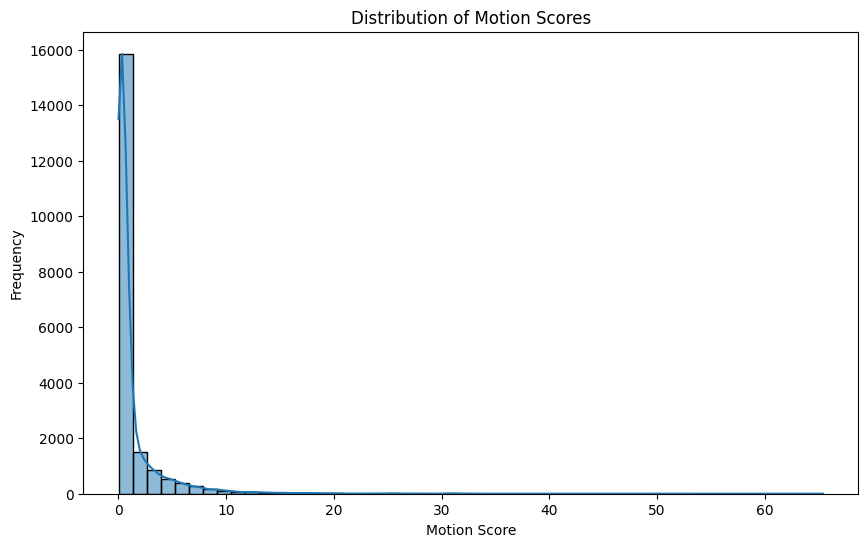


Descriptive statistics for Motion Scores:
count    20041.000000
mean         1.347398
std          3.152328
min          0.004927
25%          0.139742
50%          0.384350
75%          0.971835
max         65.418021
Name: motion_val, dtype: float64


In [12]:
#visualiozation of movement distribution
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.histplot(motion_vals_df['motion_val'].dropna(), bins=50, kde=True)
plt.title('Distribution of Motion Scores')
plt.xlabel('Motion Score')
plt.ylabel('Frequency')
plt.show()


print("\nDescriptive statistics for Motion Scores:")
print(motion_vals_df['motion_val'].describe())

In [13]:
threshold = 0.139 #based on being be around 25th percentile --> can make it less strict and closer towards median
static_frames_df = motion_vals_df[motion_vals_df['motion_val'] <= threshold].copy()
print(static_frames_df.head())
print(static_frames_df.info())

    activity                                         video_file  frame  \
188    Cobra  /Users/azimusmanov/Documents/CS_396/final_proj...    205   
192    Cobra  /Users/azimusmanov/Documents/CS_396/final_proj...    209   
196    Cobra  /Users/azimusmanov/Documents/CS_396/final_proj...    213   
197    Cobra  /Users/azimusmanov/Documents/CS_396/final_proj...    214   
203    Cobra  /Users/azimusmanov/Documents/CS_396/final_proj...    220   

     motion_val  
188    0.105670  
192    0.092287  
196    0.102145  
197    0.076063  
203    0.131830  
<class 'pandas.core.frame.DataFrame'>
Index: 4981 entries, 188 to 20009
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   activity    4981 non-null   object 
 1   video_file  4981 non-null   object 
 2   frame       4981 non-null   int64  
 3   motion_val  4981 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 194.6+ KB
None


In [14]:
cleaned_frames = pd.merge(
    complete_pose_angle_df,
    static_frames_df[['activity', 'video_file', 'frame']],
    on=['activity', 'video_file', 'frame'],
    how='inner'
)

print(cleaned_frames.head())
print(cleaned_frames.info())

output_path = 'cleaned_frames.csv'
cleaned_frames.to_csv(output_path, index=False)
print(f'Saved to {output_path}')


  activity                                         video_file  frame  kp_idx  \
0     Tree  /Users/azimusmanov/Documents/CS_396/final_proj...    101       0   
1     Tree  /Users/azimusmanov/Documents/CS_396/final_proj...    101       1   
2     Tree  /Users/azimusmanov/Documents/CS_396/final_proj...    101       2   
3     Tree  /Users/azimusmanov/Documents/CS_396/final_proj...    101       3   
4     Tree  /Users/azimusmanov/Documents/CS_396/final_proj...    101       4   

          x         y         z  visibility  left_elbow_angle  \
0  0.497937  0.060919 -0.135416    0.981481         57.684664   
1  0.503908  0.046549 -0.112502    0.974414         57.684664   
2  0.506984  0.048891 -0.112738    0.972332         57.684664   
3  0.511460  0.051669 -0.112666    0.975149         57.684664   
4  0.493619  0.044271 -0.119777    0.980261         57.684664   

   right_elbow_angle  left_knee_angle  left_hip_angle  right_knee_angle  \
0          50.604911         20.90085       12.036197

In [15]:
#loading it back in
data_training_df = pd.read_csv('cleaned_frames.csv')


In [16]:
from sklearn.model_selection import train_test_split


coordinates_df = data_training_df[['activity', 'video_file', 'frame', 'kp_idx', 'x', 'y', 'z']]
X_kp_data = coordinates_df.pivot_table(
    index = ['activity', 'video_file', 'frame'],
    columns = 'kp_idx',
    values = ['x', 'y', 'z']
)

X_kp_data.columns = [f'{coord}_{idx}' for coord, idx in X_kp_data]
X_kp_data = X_kp_data.reset_index()

X_angle_data = data_training_df[['activity', 'video_file', 'frame', 'left_elbow_angle', 'right_elbow_angle', 'left_knee_angle',
     'right_knee_angle', 'left_hip_angle', 'right_hip_angle']].drop_duplicates(subset = ['activity', 'video_file', 'frame'])


X_kp_angle_combined = pd.merge(X_kp_data, X_angle_data, on = ['activity', 'video_file', 'frame'], how = 'inner')

y = X_kp_angle_combined['activity'] # Corrected: y should be derived from X_kp_angle_combined
X = X_kp_angle_combined.drop(columns = ['activity', 'video_file', 'frame'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [18]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'X train head: {X_train.head()}')
print(f'y train head: {y_train.head()}')

X_train shape: (3984, 105)
y_train shape: (3984,)
X_test shape: (997, 105)
y_test shape: (997,)
X train head:            x_0       x_1       x_2       x_3       x_4       x_5       x_6  \
4620  0.509613  0.517179  0.520295  0.524730  0.506212  0.502055  0.497926   
78    0.666106  0.661637  0.660212  0.658638  0.660942  0.658718  0.656116   
4205  0.555022  0.554574  0.554060  0.553629  0.552763  0.550681  0.547805   
2324  0.595608  0.606242  0.607613  0.608982  0.606566  0.608212  0.610099   
4975  0.571175  0.578799  0.583346  0.587632  0.566928  0.563463  0.560268   

           x_7       x_8       x_9  ...      z_29      z_30      z_31  \
4620  0.527834  0.493078  0.516911  ...  0.089782  0.018996  0.014190   
78    0.638863  0.637993  0.658879  ...  0.223864 -0.095464  0.146141   
4205  0.536716  0.531177  0.544705  ...  0.091720 -0.146707  0.067865   
2324  0.619370  0.620090  0.594921  ...  0.067618 -0.105803 -0.015084   
4975  0.592633  0.556733  0.579281  ...  0.026315  0.033

Model Training

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = -1)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
import joblib
joblib.dump(model, 'yoga_pose_model.pkl')

['yoga_pose_model.pkl']

Model Evaluation

Accuracy: 1.0
classification report:               precision    recall  f1-score   support

       Cobra       1.00      1.00      1.00       345
 DownwardDog       1.00      1.00      1.00       362
       Lunge       1.00      1.00      1.00       150
        Tree       1.00      1.00      1.00       140

    accuracy                           1.00       997
   macro avg       1.00      1.00      1.00       997
weighted avg       1.00      1.00      1.00       997



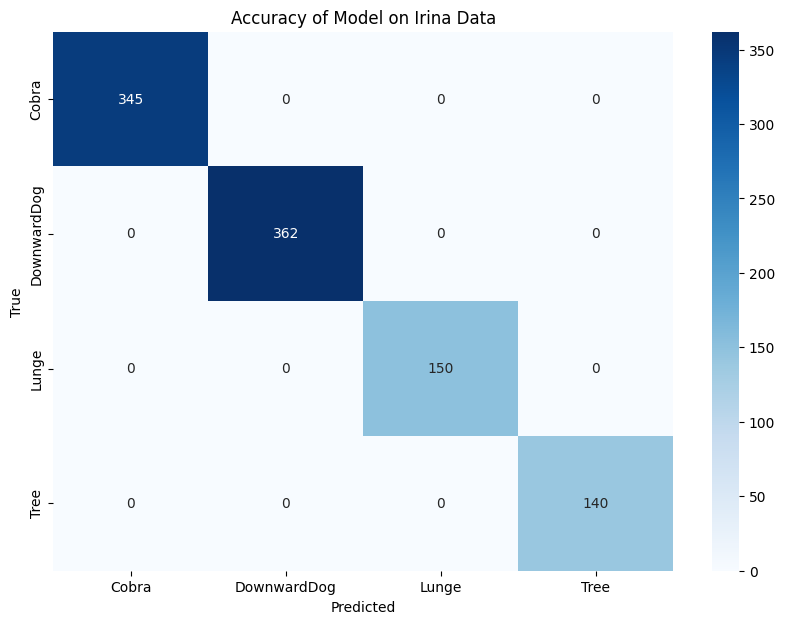

In [21]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print(f'classification report: {classification_report(y_test, y_pred)}')

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10, 7))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = model.classes_, yticklabels = model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Accuracy of Model on Irina Data')
plt.show()

Retraining model for own purposes

['activity', 'video_file', 'frame', 'x_0', 'x_1']
Accuracy: 0.9979939819458375
Accuracy: 0.9979939819458375


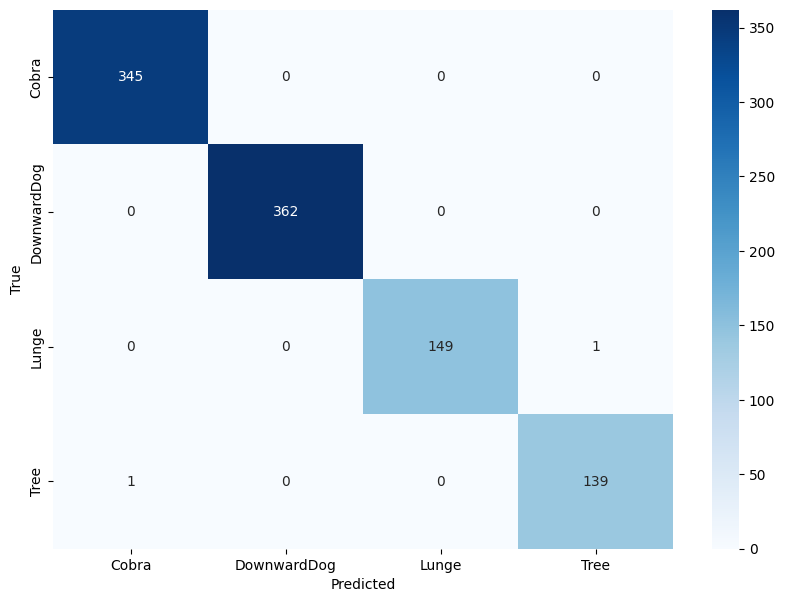

Saved model to yoga_pose_model.pkl


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

def calculate_angles_from_kp(kp1, kp2, kp3):
  kp1 = np.array(kp1)
  kp2 = np.array(kp2)
  kp3 = np.array(kp3)

  vec1 = kp1 - kp2
  vec2 = kp3 - kp2

  dot = np.dot(vec1, vec2)
  norm1 = np.linalg.norm(vec1)
  norm2 = np.linalg.norm(vec2)

  if norm1 == 0 or norm2 == 0: return 0.0
  cosine_ang = dot / (norm1 * norm2)
  cosine_ang = np.clip(cosine_ang, -1.0, 1.0)
  return np.degrees(np.arccos(cosine_ang))

df = pd.read_csv('cleaned_frames.csv')

if 'kp_idx' in df.columns and 'x' in df.columns:
  df_wide = df.pivot_table(index=['activity', 'video_file', 'frame'], columns='kp_idx', values=['x', 'y', 'z'])

  df_wide.columns = [f'{col[0]}_{col[1]}' for col in df_wide.columns]
  df_wide = df_wide.reset_index()
  df = df_wide
  print(df.columns[:5].tolist())

new_angles = []

for i, row in df.iterrows():
  def get_v(idx):
    return [row[f'x_{idx}'], row[f'y_{idx}'], row[f'z_{idx}']]

  # MP joint indices
  L_SHOULDER, R_SHOULDER = 11, 12
  L_ELBOW, R_ELBOW = 13, 14
  L_WRIST, R_WRIST = 15, 16
  L_HIP, R_HIP = 23, 24
  L_KNEE, R_KNEE = 25, 26
  L_ANKLE, R_ANKLE = 27, 28

  row_angles = {}
  row_angles['left_elbow_angle'] = calculate_angles_from_kp(get_v(L_SHOULDER), get_v(L_ELBOW), get_v(L_WRIST))
  row_angles['right_elbow_angle'] = calculate_angles_from_kp(get_v(R_SHOULDER), get_v(R_ELBOW), get_v(R_WRIST))
  row_angles['left_knee_angle'] = calculate_angles_from_kp(get_v(L_HIP), get_v(L_KNEE), get_v(L_ANKLE))
  row_angles['right_knee_angle'] = calculate_angles_from_kp(get_v(R_HIP), get_v(R_KNEE), get_v(R_ANKLE))
  row_angles['left_hip_angle'] = calculate_angles_from_kp(get_v(L_SHOULDER), get_v(L_HIP), get_v(L_KNEE))
  row_angles['right_hip_angle'] = calculate_angles_from_kp(get_v(R_SHOULDER), get_v(R_HIP), get_v(R_KNEE))
  row_angles['left_shoulder_angle'] = calculate_angles_from_kp(get_v(L_HIP), get_v(L_SHOULDER), get_v(L_ELBOW))
  row_angles['right_shoulder_angle'] = calculate_angles_from_kp(get_v(R_HIP), get_v(R_SHOULDER), get_v(R_ELBOW))

  new_angles.append(row_angles)

# Create a new dataframe w/ only corrected angles
angles_df = pd.DataFrame(new_angles)
angles_df['activity'] = df['activity'] # Add label back in

feature_cols = [
    'left_elbow_angle', 'right_elbow_angle',
    'left_knee_angle', 'right_knee_angle',
    'left_hip_angle', 'right_hip_angle',
    'left_shoulder_angle', 'right_shoulder_angle',
]

X = angles_df[feature_cols]
y = angles_df['activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
acc = model.score(X_test, y_test)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10, 7))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = model.classes_, yticklabels = model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

joblib.dump(model, 'yoga_pose_model.pkl')
print('Saved model to yoga_pose_model.pkl')


Inference-specific feature extraction (with sliding window)

In [23]:
import cv2
import mediapipe as mp
import numpy as np
import joblib
from collections import deque
import warnings
import os

warnings.filterwarnings("ignore")
model = joblib.load('yoga_pose_model.pkl')

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

confidence_thresh = 0.65

def calculate_angles_from_kp(kp1, kp2, kp3, offset = 0):
  ## It seems like angles are generally 10-20 deg off or something... so I just added 10
  kp1 = np.array(kp1)
  kp2 = np.array(kp2)
  kp3 = np.array(kp3)
  vec1 = kp1 - kp2
  vec2 = kp3 - kp2
  dot = np.dot(vec1, vec2)
  norm1 = np.linalg.norm(vec1)
  norm2 = np.linalg.norm(vec2)
  if norm1 == 0 or norm2 == 0: return 0.0
  cosine_ang = dot / (norm1 * norm2)
  cosine_ang = np.clip(cosine_ang, -1.0, 1.0)
  angle = np.arccos(cosine_ang)
  d_angle = np.degrees(angle)
  # if d_angle > 160: d_angle += (d_angle - 160) * 0.5
  return d_angle + offset

def extract_features_single_frame(landmarks):
  def get_coords(idx):
    kp = landmarks[idx]
    return [kp.x, kp.y, kp.z]

  L_SHOULDER, R_SHOULDER = 11, 12
  L_ELBOW, R_ELBOW = 13, 14
  L_WRIST, R_WRIST = 15, 16
  L_HIP, R_HIP = 23, 24
  L_KNEE, R_KNEE = 25, 26
  L_ANKLE, R_ANKLE = 27, 28

  angles = {}
  angles['left_elbow_angle'] = calculate_angles_from_kp(get_coords(L_SHOULDER), get_coords(L_ELBOW), get_coords(L_WRIST))
  angles['right_elbow_angle'] = calculate_angles_from_kp(get_coords(R_SHOULDER), get_coords(R_ELBOW), get_coords(R_WRIST))
  angles['left_knee_angle'] = calculate_angles_from_kp(get_coords(L_HIP), get_coords(L_KNEE), get_coords(L_ANKLE))
  angles['right_knee_angle'] = calculate_angles_from_kp(get_coords(R_HIP), get_coords(R_KNEE), get_coords(R_ANKLE))
  angles['left_hip_angle'] = calculate_angles_from_kp(get_coords(L_SHOULDER), get_coords(L_HIP), get_coords(L_KNEE))
  angles['right_hip_angle'] = calculate_angles_from_kp(get_coords(R_SHOULDER), get_coords(R_HIP), get_coords(R_KNEE))
  angles['left_shoulder_angle'] = calculate_angles_from_kp(get_coords(L_HIP), get_coords(L_SHOULDER), get_coords(L_ELBOW))
  angles['right_shoulder_angle'] = calculate_angles_from_kp(get_coords(R_HIP), get_coords(R_SHOULDER), get_coords(R_ELBOW))

  # Limb visibility
  vis = {}
  vis['left_elbow_angle'] = landmarks[L_ELBOW].visibility
  vis['right_elbow_angle'] = landmarks[R_ELBOW].visibility
  vis['left_knee_angle'] = landmarks[L_KNEE].visibility
  vis['right_knee_angle'] = landmarks[R_KNEE].visibility
  vis['left_hip_angle'] = landmarks[L_HIP].visibility
  vis['right_hip_angle'] = landmarks[R_HIP].visibility
  vis['left_shoulder_angle'] = landmarks[L_SHOULDER].visibility
  vis['right_shoulder_angle'] = landmarks[R_SHOULDER].visibility

  angle_features = [
      angles['left_elbow_angle'], angles['right_elbow_angle'],
      angles['left_knee_angle'], angles['right_knee_angle'],
      angles['left_hip_angle'], angles['right_hip_angle'],
      angles['left_shoulder_angle'], angles['right_shoulder_angle']
  ]
  return np.array(angle_features), angles, vis

def reconstruct_angles(feature_vector):
  return {
      'left_elbow_angle': feature_vector[0],
      'right_elbow_angle': feature_vector[1],
      'left_knee_angle': feature_vector[2],
      'right_knee_angle': feature_vector[3],
      'left_hip_angle': feature_vector[4],
      'right_hip_angle': feature_vector[5],
      'left_shoulder_angle': feature_vector[6],
      'right_shoulder_angle': feature_vector[7]
      }

I0000 00:00:1764105384.183128 30238708 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4


W0000 00:00:1764105384.249294 30359462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764105384.256232 30359462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Feedback criteria + actuation

In [25]:
feedback_rules = {
    "Lunge": {
        "front_knee": (75, 110, "Bend front knee to 90°"),
        "back_knee": (160, 185, "Straighten back leg"),
    },
    "Tree": {
        "bent_knee": (30, 85, "Bend knee more"),
        "standing_knee": (165, 185, "Straighten standing leg"),
    },
    "DownwardDog": {
        "legs": (160, 185, "Straighten legs"),
        "back": (40, 110, "Bend hip more"),
        "arms": (140, 185, "Straighten arms"),
        "chest": (135, 195, "Tuck chest in more")
    },
    "Cobra": {
        "back": (90, 145, "Arch back more"),
        "arms": (150, 185, "Straighten arms")
    }
}

def get_feedback(pose_name, angles_dict, vis_dict):

  if pose_name not in feedback_rules: return ""
  rules = feedback_rules[pose_name]

  l_knee = angles_dict['left_knee_angle']
  r_knee = angles_dict['right_knee_angle']
  mapping = {}

  if pose_name == 'Tree':
    if l_knee < r_knee:
      mapping = {'bent_knee':'left_knee_angle', 'standing_knee':'right_knee_angle'}
    else:
      mapping = {'bent_knee':'right_knee_angle', 'standing_knee':'left_knee_angle'}

  elif pose_name == 'Lunge':
    if l_knee < r_knee:
      mapping = {'front_knee':'left_knee_angle', 'back_knee':'right_knee_angle'}
    else:
      mapping = {'front_knee':'right_knee_angle', 'back_knee':'left_knee_angle'}
    # mapping['arms'] = ['left_elbow_angle', 'right_elbow_angle']

  elif pose_name == 'DownwardDog':
    mapping['legs'] = ['left_knee_angle', 'right_knee_angle']
    mapping['back'] = ['left_hip_angle', 'right_hip_angle']
    mapping['arms'] = ['left_elbow_angle', 'right_elbow_angle']
    mapping['chest'] = ['left_shoulder_angle', 'right_shoulder_angle']

  elif pose_name == 'Cobra':
    mapping['back'] = ['left_hip_angle', 'right_hip_angle']
    mapping['arms'] = ['left_elbow_angle', 'right_elbow_angle']

  visual_thresh = 0.7

  for rule_part, (min_v, max_v, msg) in rules.items():
    names = mapping.get(rule_part)
    if not names: continue
    if not isinstance(names, list): names = [names]

    for name in names:
      if vis_dict and vis_dict.get(name, 0) < visual_thresh:
        continue
      val = angles_dict.get(name, 0)
      if val < min_v or val > max_v:
        return msg

  return "Good job!"

def process_video_with_window(video_path, output_path, window_seconds=1, target_height=480, rotate=False):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
      print(f"Error opening video file: {video_path}")
      return

    orig_w = int(cap.get(3))
    orig_h = int(cap.get(4))
    fps = int(cap.get(5))

    ################ temp edit for processing speed - idk I think it works faster at 480p ######################
    # scale_ratio = target_height / float(orig_h)
    # new_height = target_height
    # new_width = int(orig_w * scale_ratio)
    new_height = orig_h
    new_width = orig_w  #jk too lazy to fix the other variables
    ############################################################################################################


    #idk why but for whatever reason avi and MJPG works better
    if not output_path.endswith('.avi'):
      output_path = output_path.rsplit('.', 1)[0] + '.avi'
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'MJPG'), fps, (new_width, new_height))

    buffer_size = int(fps * window_seconds)
    feature_buffer = deque(maxlen=buffer_size)
    vis_buffer = deque(maxlen=buffer_size)

    print(f"Processing w/ confidence threshold at {confidence_thresh*100}%...")

    try:
      while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
          break

        frame = cv2.resize(frame, (new_width, new_height))
        if rotate:
          frame = cv2.rotate(frame, cv2.ROTATE_180)

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(image)

        pose_text = "Buffering..."
        feedback_text = ""
        debug_angles = {}
        confidence = 0.0

        if results.pose_world_landmarks:
          if results.pose_landmarks:
            mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
          raw_vec, angles, vis = extract_features_single_frame(results.pose_world_landmarks.landmark)

          feature_buffer.append(raw_vec)
          vis_buffer.append(vis)

          if len(feature_buffer) == buffer_size:
            avg_vec = np.mean(feature_buffer, axis=0)

            probabilities = model.predict_proba(avg_vec.reshape(1, -1))[0]
            confidence = np.max(probabilities)
            pred_idx = np.argmax(probabilities)
            pred_label = model.classes_[pred_idx]

            if confidence > confidence_thresh:
              pose_text = f"{pred_label} ({int(confidence*100)}%)"

              # visual confidence for limbs hidden from camera
              avg_vis = {}
              for key in vis:
                avg_vis[key] = np.mean([v[key] for v in vis_buffer])
              avg_angles_dict = reconstruct_angles(avg_vec)

              feedback_text = get_feedback(pred_label, avg_angles_dict, avg_vis)

              # Angles on display for debugging
              debug_angles = avg_angles_dict
            else:
              pose_text = "Waiting..."
              feedback_text = "Please hold a pose"
          else:
            pose_text = f"Buffering..."

        # UI Drawing
        cv2.rectangle(frame, (0,0), (new_width, 100), (0,0,0), -1)

        status_color = (255, 255, 255)
        if pose_text == "Waiting...": status_color = (192, 192, 192)

        cv2.putText(frame, f"Pose: {pose_text}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, status_color, 2)

        color = (0, 255, 0) if "Good" in feedback_text else (0, 0, 255)
        cv2.putText(frame, f"{feedback_text}", (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)

        if debug_angles and pose_text != "Waiting...":
          y_offset = 150
          relevant_keys = []

          if pred_label == 'Cobra':
            relevant_keys = ['left_hip_angle', 'right_hip_angle', 'left_elbow_angle', 'right_elbow_angle']
          elif pred_label == 'Tree':
            relevant_keys = ['left_knee_angle', 'right_knee_angle']
          elif pred_label == 'Lunge':
            relevant_keys = ['left_knee_angle', 'right_knee_angle']
          elif pred_label == 'DownwardDog':
            relevant_keys = ['left_hip_angle', 'right_hip_angle', 'left_knee_angle', 'right_knee_angle',
                             'left_elbow_angle', 'right_elbow_angle', 'left_shoulder_angle', 'right_shoulder_angle']

          for key in relevant_keys:
            val = debug_angles.get(key, 0)
            vis_score = avg_vis.get(key, 0)
            if vis_score < .7:
              text_color = (128,128,128)
            else:
              text_color = (255,255,0)
            cv2.putText(frame, f"{key}: {int(val)} (v:{vis_score:.2f})",(20, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 2)
            y_offset += 30
        out.write(frame)

    except Exception as e:
      print(f"Error: {e}")
    finally:
      cap.release()
      out.release()
      print("Done processing.")

In [26]:
# Example: Process a test video (update path to your local video)
# process_video_with_window('/Users/azimusmanov/Documents/CS_396/final_proj/Activities/DownwardDog/test_video.MOV', 'output_confident.avi')
print('Update the video path above to test video processing')


Update the video path above to test video processing


In [27]:
#shit don't work

# from IPython.display import HTML
# from base64 import b64encode
# import os

# def show_video(video_path, width=640):
#     if not os.path.exists(video_path):
#         print(f"Error: Video file not found at {video_path}")
#         return

#     mp4 = open(video_path,'rb').read()
#     data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

#     return HTML(f"""
#     <video width={width} controls>
#           <source src="{data_url}" type="video/mp4">
#     </video>
#     """)
# show_video('output_smoothed.MOV')